# Beta Version
In this notebook, we will perform Bayesian inference (BI) for tension measurements in pendant drop method. Pendant drop is an optical method, 
surface and interfacial tension measurements can be performed optically using pendant drop shape analysis. The shape of the drop hanging from a needle is determined from the balance of forces which include the Surface tension of the liquid being investigated. pendant drop method The surface or interfacial tension can be related to the drop shape by the equation ;
$$γ = ΔρgR_0/β$$
where $γ$ is the surface tension , $Δρ$ is the density difference between fluids , $g$ is the gravitational constant , $R_0$ is the drop radius of curvature at the apex and $β$ is the shape factor.

In this project, assume that other data are known and accurate, and consider only the effect of surface tension $\gamma$ and droplet volume $V_0$ on droplet shape.

First we need to import the image generation codes and some standard libraries.

In [2]:
# image generation codes
from fun_genSingleDrop import *
from fun_opti import *
from fun_preprocess import *

# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from numpy import trapz
import random
import math as m

# use Latex for the lables in plots
#plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams['text.usetex'] = True
#plt.rcParams.update({'font.size': 22})

# fix the seed for the RNG
RANDOM_SEED=5109
np.random.seed(RANDOM_SEED)



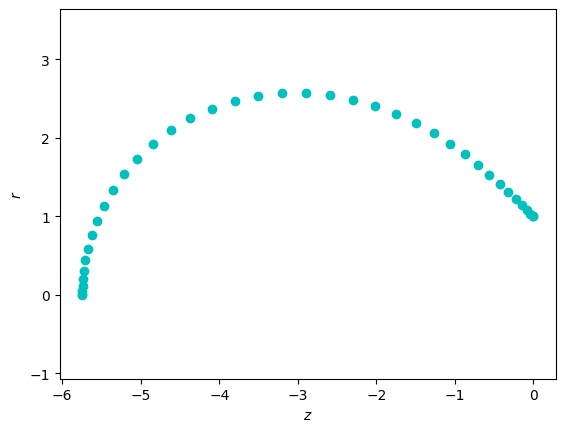

In [34]:
r_a,z_a=genSingleDrop(sigma=75,volume0=10,rneedle=0.5,output=1)
plt.plot(z_a,r_a,'co')
plt.xlabel("$z$")
plt.ylabel("$r$")
plt.axis('equal')
plt.show()

In [28]:
# add white noise on z and r
wn_mu=0
wn_sigma=0.05
r_w=r_a
z_w=z_a

for i in range (r_w.size):
    r_w[i] += random.gauss(wn_mu,wn_sigma)
    z_w[i] += random.gauss(wn_mu,wn_sigma)


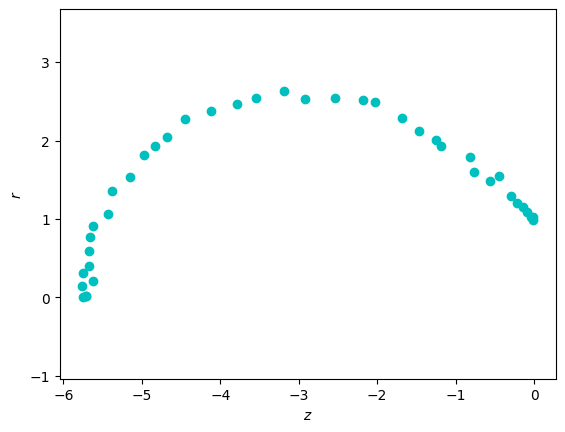

In [37]:
plt.plot(z_w,r_w,'co')
plt.xlabel("$z$")
plt.ylabel("$r$")
plt.axis('equal')
plt.show()

And then use the codes to generate a synthtic image as the experimental image. And we denote the generator as a function$$G(\gamma,V_0 )$$. Since in one experiment, the tension is not changed, then we generate 10 different images by change the volume. We denote this progress as $Images=G(\gamma,V_0 )$, where $\{V_0|v_1,v_2,...v_{10}\}$


BI is based on Bayes' rule, which is given by $$\pi(\boldsymbol{m}|\boldsymbol{y}) = \frac{\pi(\boldsymbol{y}|\boldsymbol{m})\pi(\boldsymbol{m})}{\pi(\boldsymbol{y})}\text{,}$$ which should be read as follows: the probability for a parameter value given measured data (with known deterministic parameters) is equal to the probility of observing the data given the parameter times the prior probability of the parameter over the probability of observing the data. For brevity, we introduce the following short-hand notation for the case of multiple measurement point: $$\pi(\boldsymbol{m}|\boldsymbol{y})=\pi(\boldsymbol{m}|\boldsymbol{y}_1,\boldsymbol{y}_2 \dots \boldsymbol{y}_N),$$ and similarly for $\pi(\boldsymbol{y}|\boldsymbol{m})$ and $\pi(\boldsymbol{y})$.

The commonly used names of the terms in Bayes' rule are as follows:
- $\pi(\boldsymbol{m}|\boldsymbol{y})$: posterior probability
- $\pi(\boldsymbol{y}|\boldsymbol{m})$: likelihood
- $\pi(\boldsymbol{m})$: prior probability
- $\pi(\boldsymbol{y})$: marginal probability (sometimes called evidence)


## Prior
For the current expample of pendant drop, we assume that we have reason to believe that the surface tension will be around $\gamma=70$ and droplet volume will be around $V_0=10$, but we are not sure about them, so we give it a standard deviation of $\sigma_{\gamma}=5$ and $\sigma_{V_0}=2$. Assuming a Gaussian prior, we obtain
$$\pi(\gamma,V_0)=(2\pi \sigma _{\gamma} \sigma _{V_0})^{-1} exp [-\frac{1}{2}(\frac{(\gamma-\mu _{\gamma})^2}{\sigma _{\gamma} ^2}+\frac{(V_0-\mu _{V_0})^2}{\sigma _{V_0} ^2})]$$

$$\pi(\gamma,V_0=10)=(2\pi \sigma _{\gamma} \sigma _{V_0})^{-1} exp [-\frac{1}{2}(\frac{(\gamma-\mu _{\gamma})^2}{\sigma _{\gamma} ^2}+\frac{(V_0-\mu _{V_0})^2}{\sigma _{V_0} ^2})]$$

In [3]:
def normal(u,sig,x):
    y = np.exp(-(x - u) ** 2 / (2 * sig ** 2)) / (m.sqrt(2*m.pi)*sig)
    return y

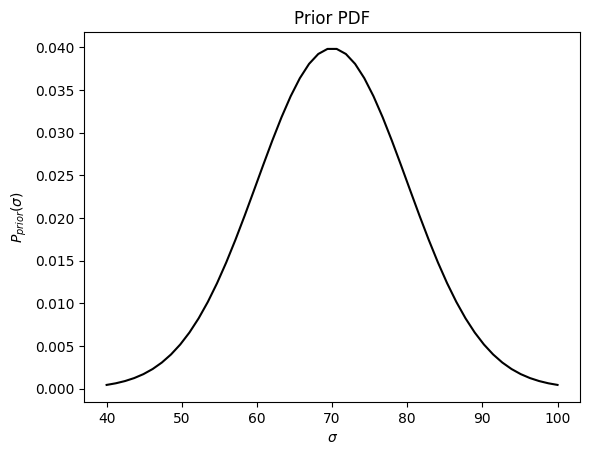

In [4]:
u_pri,sig_pri=70,10
x_pri = np.linspace(u_pri - 3*sig_pri, u_pri + 3*sig_pri, 50)
prior= normal(u_pri,sig_pri,x_pri)

plt.plot(x_pri,prior,'black')
plt.xlabel('$\\sigma$')
plt.ylabel('$P_{prior}(\\sigma)$')
plt.title('Prior PDF')
plt.show()

## Likelihood
Next, we will consider about likelihood, we define a cost function as the likelihood function. We compare the pre-processed experimental image and synthetic image. We use a equation to denote this process.
$$ L(\gamma,V)=1-\frac{(image \odot G(\gamma, V)).[false]}{image.[droplet]} $$  
where the numerator $(image \odot G(\gamma, V)).[false]$ means the number of pixels that valued false in the result of XNOR operation between the experimental image and synthetic image, i.e. two images have different value at this pixel. And the denominator $image.[droplet]$ means the number of pixels that valued '0'(color is black) in the experimental image which means this pixel is droplet.

### Optimization and NOV Calculate

In [4]:
from fun_opti import *
import dill
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from PIL import Image
import numpy as np
import random
import time
import math as m

In [5]:
def optimize_NOV(sv,path_ori=os.path.abspath('./images_paper/sase_s73.00_v18.50_rn0.50_ln4.00_needle.jpg'),output=0,append=1):
    sigma=sv[0]
    v0=sv[1]

    # preprosessing the ori image
    exp_zoom=reshape_Exp(path_ori)

    # gen and post processing the syn image
    syn_array,_,_,_=gen_Drop(sigma=sigma,volume0=v0,rneedle=0.5)# Remember to check the rneedle!
    # syn_arr,wmax,rneedle=gen_doplet_v5(sigma=sigma,volume0=v0,rneedle=0.5)

    # crop the margin of syn image and scale it
    syn_zoom=scale_Syn(syn_array)

    
    if output==0:
        NOV=cal_NOV(exp_zoom=exp_zoom,syn_zoom=syn_zoom,output=output)
        if append==1:
            Xs.append(sv)
            NOVs.append(NOV)  
        return NOV

    elif output==1:
        NOV=cal_NOV(exp_zoom=exp_zoom,syn_zoom=syn_zoom,output=output)
        print ('x=%.2f,%.2f and NOV=%.4f'%(sv[0],sv[1],NOV))
        if append==1:
            Xs.append(sv)
            NOVs.append(NOV)  
        return NOV
    else:     
        NOV,C=cal_NOV(exp_zoom=exp_zoom,syn_zoom=syn_zoom,output=output)
        return NOV,C

In [6]:
s=random.randint(20,100)
v=random.randint(0,40)
print(s,v)

68 7


1st time 68, 9 --> 47.43, 11.87//
2nd time 74, 22--> 74.35, 21.90//
3rd time 70, 15--> 66.60, 16.09//
4th time 59, 3 --> 22.36, 5.45 //0.431


In [7]:
# Calculate Likelihood
import scipy.optimize

Xs=[]
NOVs=[]

x0=np.asarray((s,v))


# use scipy obtimaize the parameter
opStart=time.time()
print('Optimization Start')
#sigma; v0; length_Ne,r_Ne; x,y; scaling_rate;
res=scipy.optimize.minimize(optimize_NOV,x0,method='nelder-mead') #SLSQP #nelder-mead
#res=scipy.optimize.minimize(obtimize_v5,x0,method='SLSQP',options={'maxiter':15})
opEnd=time.time()
print('Optimize Program Running Time: ',opEnd-opStart)


Optimization Start
Optimize Program Running Time:  215.56825423240662


In [13]:
print((res.fun))
print(m.log(res.fun))
print(m.log(1))
#print(m.log(res.fun/(m.log(1)-1)))

0.004461440407903123
-5.412283603677719
0.0


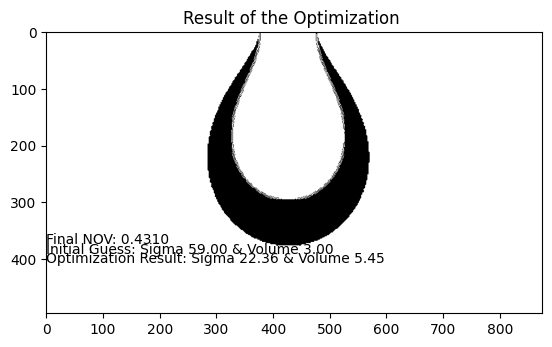

In [44]:
NOV,C=optimize_NOV(np.asarray((res.x[0],res.x[1])),output=2)
plt.imshow(C,cmap='gray')
plt.title('Result of the Optimization ')
plt.text(0,390,'Initial Guess: Sigma %.2f & Volume %.2f'%(x0[0], x0[1]))
plt.text(0,407,'Optimization Result: Sigma %.2f & Volume %.2f'%(res.x[0], res.x[1]))
plt.text(0,373,'Final NOV: %.4f'%(res.fun))
plt.savefig(fname='Opti_Result_RV_s%.2f_IG_s%.2f_v%.2f.png'%(73.04,x0[0],x0[1]))

### Likelihood 

In [46]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
u=res.x[0]
NOV=res.fun
sig=((1-NOV)*(2*m.pi)**(1/2))**(-1)

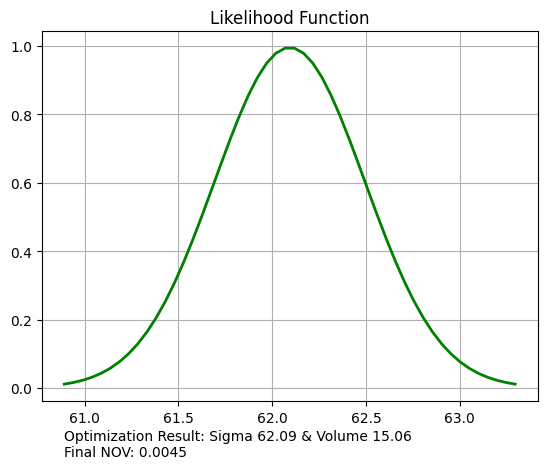

In [47]:
x = np.linspace(u - 3*sig, u + 3*sig, 50)   # x-domain
lhood1=normal(u=u,sig=sig,x=x)# 定义曲线函数
plt.plot(x, lhood1, "g", linewidth=2)    # 加载曲线
plt.grid(True)  # 网格线
plt.title('Likelihood Function')
plt.text(u - 3*sig,-(1-NOV)/6.5,'Optimization Result: Sigma %.2f & Volume %.2f'%(res.x[0], res.x[1]))
plt.text(u - 3*sig,-(1-NOV)/5,'Final NOV: %.4f'%(res.fun))
plt.show()  # 显示

## Posterior
Then, we need plot the posterior distribution for $\sigma$ using an increasing of the amount of the experimental image. $$ P_{posterior}(\gamma)=P_{prior}(\gamma_0) \cdot L(\gamma)$$ Where, P

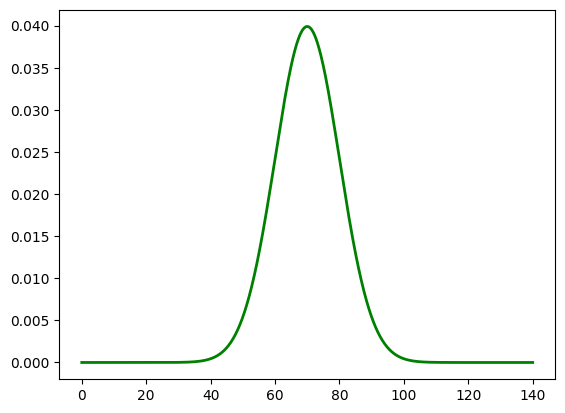

In [5]:
x = np.linspace(0,140,1000)
prior= normal(u=u_pri,sig=sig_pri,x=x)
plt.plot(x, prior, "g", linewidth=2) 
plt.show()

In [6]:
u=[22.36, 47.43, 62.09, 66.6, 74.35]
NOV=[0.431, 0.0812, 0.0045, 0.0058, 0.2884]

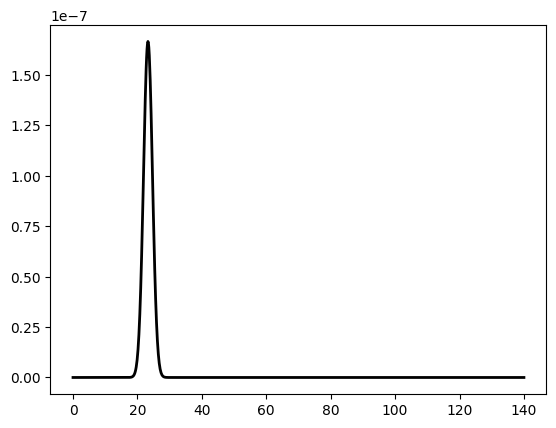

In [7]:
i=0
sig=((1-NOV[i])/2*(2*m.pi)**(1/2))**(-1)
lhood=normal(u=u[i],sig=sig,x=x)
post=prior*lhood
plt.plot(x, post, "black", linewidth=2)

22.36 0.431
47.43 0.0812
62.09 0.0045
66.6 0.0058
74.35 0.2884


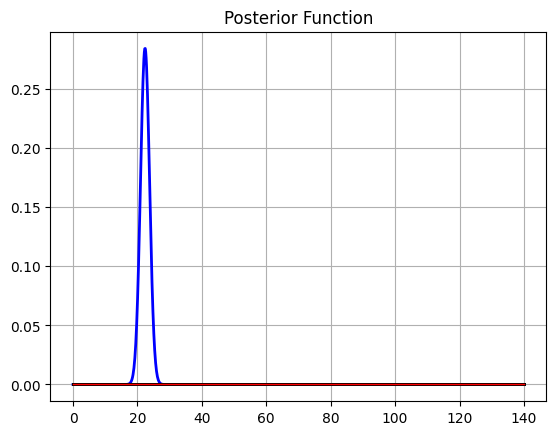

In [11]:
#plt.plot(x, prior, "g", linewidth=2)    # 加载曲线

plt.grid(True)  # 网格线
plt.title('Posterior Function')

for i in range(len(u)):
    print (u[i],NOV[i])
    sig=((1-NOV[i])/2*(2*m.pi)**(1/2))**(-1)
    if i==0:
        lhood=normal(u=u[i],sig=sig,x=x)
        post=lhood
        #plt.plot(x, post, "black", linewidth=2)
        plt.plot(x, lhood, "blue", linewidth=2)

    elif i==4:
        lhood=normal(u=u[i],sig=sig,x=x)
        post=post*lhood
        plt.plot(x, post, "red", linewidth=1)
        #plt.plot(x, lhood, "blue", linewidth=2)

    else:
        lhood=normal(u=u[i],sig=sig,x=x)
        post=post*lhood
        plt.plot(x, post, "black", linewidth=2)
        #plt.plot(x, lhood, "blue", linewidth=2)

plt.show()
